Imports and loading data from Google Drive with pandas

In [ ]:
!pip install gensim --upgrade
!pip install pyldavis
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import itertools
from gensim.models import Word2Vec
from wordcloud import WordCloud
from google.colab import drive
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Datasets/vaccine/eclass_all_with_sentiment.csv'
df = pd.read_csv(path)


Check the column names to identify features

In [2]:
list(df.columns)

['id',
 'user_name',
 'user_location',
 'user_description',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'text',
 'hashtags',
 'source',
 'retweets',
 'favorites',
 'is_retweet',
 'sentiment']

Check for null values and drop them

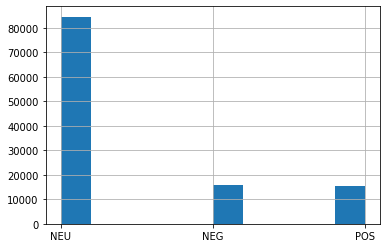

In [3]:
df.isnull().values.any()
df = df.dropna()
df['sentiment'].hist(bins=10)


Keep only lowercase characters from the text column to remove noise, and remove stopwords/links

In [4]:
df['text'] = df['text'].replace('[^a-zA-Z]', ' ',regex=True).str.lower()
df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0         folks said daikon paste could treat cytokine s...
2         coronavirus sputnikv astrazeneca pfizerbiontec...
6         bit sad claim fame success vaccination patriot...
9         covidvaccine states start getting covid vaccin...
10        deaths closing mark millions people wait pfize...
                                ...                        
340785    urban bengaluru covidvaccine availability pm f...
340786    bbmp bengaluru covidvaccine availability pm fr...
340787    urban bengaluru covidvaccine availability pm f...
340788    promote vaccines leaving stronger russia vacci...
340789    urban bengaluru covidvaccine availability pm f...
Name: text, Length: 116046, dtype: object

Statistics: sentiment distribution, most common words, most common words per sentiment


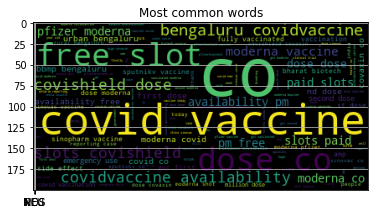

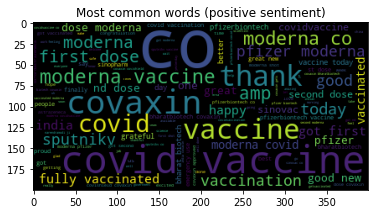

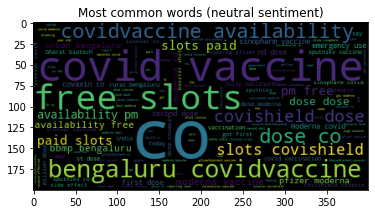

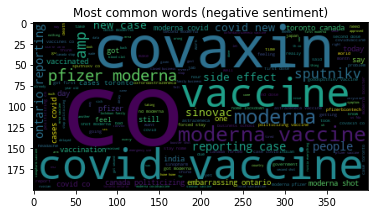

(<matplotlib.image.AxesImage at 0x7eff5d799710>,
 Text(0.5, 1.0, 'Most common words (negative sentiment)'),
 None)

In [5]:
df['sentiment'].hist(bins=10)
# Globally
total_wordcloud = WordCloud().generate(' '.join(df['text']))
plt.imshow(total_wordcloud), plt.title('Most common words')
plt.show()
# Per sentiment
pos_df = df[df['sentiment'] == 'POS']
neu_df = df[df['sentiment'] == 'NEU']
neg_df = df[df['sentiment'] == 'NEG']

pos_wordcloud = WordCloud().generate(' '.join(pos_df['text']))
neu_wordcloud = WordCloud().generate(' '.join(neu_df['text']))
neg_wordcloud = WordCloud().generate(' '.join(neg_df['text']))

plt.imshow(pos_wordcloud), plt.title('Most common words (positive sentiment)'),plt.show()
plt.imshow(neu_wordcloud), plt.title('Most common words (neutral sentiment)'),plt.show()
plt.imshow(neg_wordcloud), plt.title('Most common words (negative sentiment)'),plt.show()


Compare sentiments between different vaccines (astrazeneca-pfizer-moderna)

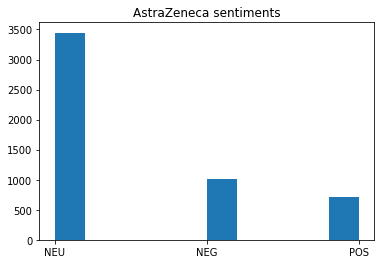

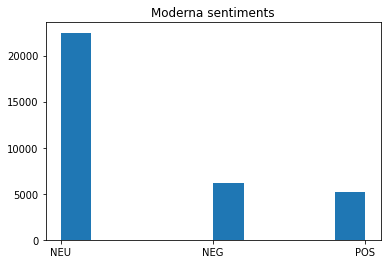

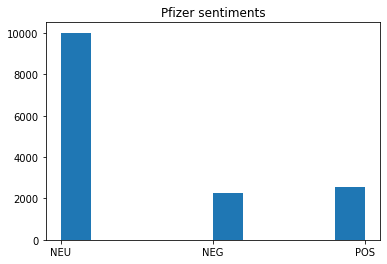

((array([10022.,     0.,     0.,     0.,     0.,  2272.,     0.,     0.,
             0.,  2553.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <a list of 10 Patch objects>),
 Text(0.5, 1.0, 'Pfizer sentiments'),
 None)

In [6]:
astra_df = df[df['text'].str.contains('astrazeneca')]
moderna_df = df[df['text'].str.contains('moderna')]
pfizer_df = df[df['text'].str.contains('pfizer') | df['text'].str.contains('biontech')]

plt.hist(astra_df['sentiment']), plt.title('AstraZeneca sentiments'), plt.show()
plt.hist(moderna_df['sentiment']), plt.title('Moderna sentiments'), plt.show()
plt.hist(pfizer_df['sentiment']), plt.title('Pfizer sentiments'), plt.show()

Plot number of tweets per month

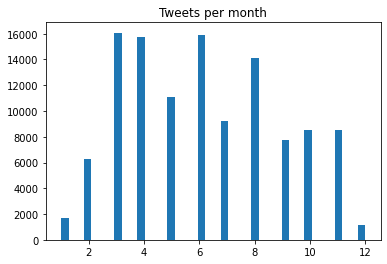

((array([ 1703.,     0.,     0.,  6247.,     0.,     0.,     0., 16079.,
             0.,     0., 15718.,     0.,     0.,     0., 11076.,     0.,
             0.,     0., 15919.,     0.,     0.,  9241.,     0.,     0.,
             0., 14135.,     0.,     0.,     0.,  7725.,     0.,     0.,
          8514.,     0.,     0.,     0.,  8528.,     0.,     0.,  1161.]),
  array([ 1.   ,  1.275,  1.55 ,  1.825,  2.1  ,  2.375,  2.65 ,  2.925,
          3.2  ,  3.475,  3.75 ,  4.025,  4.3  ,  4.575,  4.85 ,  5.125,
          5.4  ,  5.675,  5.95 ,  6.225,  6.5  ,  6.775,  7.05 ,  7.325,
          7.6  ,  7.875,  8.15 ,  8.425,  8.7  ,  8.975,  9.25 ,  9.525,
          9.8  , 10.075, 10.35 , 10.625, 10.9  , 11.175, 11.45 , 11.725,
         12.   ]),
  <a list of 40 Patch objects>),
 Text(0.5, 1.0, 'Tweets per month'),
 None)

In [7]:
dates = df['date'].tolist()
months = []
for cur_date in dates:
  months.append(int(cur_date[5:7]))

plt.hist(months, bins= 40), plt.title('Tweets per month'), plt.show()

Check average number of user friends per sentiment

In [8]:
pos_friends = df[df['sentiment']=='POS']['user_friends'].astype(int)
neg_friends = df[df['sentiment']=='NEG']['user_friends'].astype(int)
pos_friends.mean(), neg_friends.mean()

(1553.0245948888746, 1598.4483781395936)

As was found earlier, there is a huge class imbalance between neutral tweets and the rest, we will use subsampling to combat that and check performance. Later on we can also try techniques that assign different weights and check again on the entire dataset. 


In [ ]:
print(len(df[df['sentiment'] == 'NEU']), len(df[df['sentiment'] == 'POS']), len(df[df['sentiment'] == 'NEG']))
df = df.sample(frac=1)
subsampled_df = df[df['sentiment'] == 'NEU'][:int(0.15*len(df))]
print('Subsampled dataframe with neutral sentiments length: ', len(subsampled_df))


Create 80/20 train/test dataset

In [10]:
combined_df = pd.concat([subsampled_df,df[df['sentiment'] == 'NEG'], df[df['sentiment'] == 'POS']])
combined_df = combined_df[['text', 'sentiment']]
X_train, X_test, y_train, y_test = train_test_split(combined_df['text'], combined_df['sentiment'], test_size=0.2)


Vectorization: Bag of words/Tf-idf

In [11]:
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_bow = bow_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Word embeddings from scratch with gensim

In [ ]:
# Create Word2Vec representation.
print('Training Word2Vec model (after tokenization)...')
tokenized_X_train = [nltk.word_tokenize(tweet) for tweet in X_train]
tokenized_X_test = [nltk.word_tokenize(tweet) for tweet in X_test]
# Learn word vectors from the corpus, dimensionality is 100
model = Word2Vec(tokenized_X_train, vector_size=100, window=5, min_count=5, workers=4)
model.train(tokenized_X_train, total_examples=len(tokenized_X_train), epochs=5)
X_train_w2v = []
print('Transforming train tweets to w2v representation...')

for tweet in tokenized_X_train:
    if len(tweet) > 0:
        text = [word for word in tweet if word in model.wv.key_to_index]
    else:
        text = ['empty']
    # Take the average of each vector
    w2v_tweet = np.mean(model.wv[text], axis=0)
    X_train_w2v.append(w2v_tweet)
  
# Sanity check and conversion to numpy array
print('Processed this number of tweets: ', len(X_train_w2v))
X_train_w2v = np.array(X_train_w2v)
print('Train corpus shape after word2vec conversion', X_train_w2v.shape)
# Also transform the test set for usage later on
X_test_w2v = []
for tweet in tokenized_X_test:
    if len(tweet) > 0:
        text = [word for word in tweet if word in model.wv.key_to_index]
    else:
        text = ['empty']
    # Take the average of each vector
    w2v_news = np.mean(model.wv[text], axis=0)
    X_test_w2v.append(w2v_news)

# Sanity check and conversion to numpy array
print('Processed this number of tweets: ', len(X_test_w2v))
X_test_w2v = np.array(X_test_w2v)
print('Test corpus shape after word2vec conversion', X_test_w2v.shape)

LDA topic modelling: Lemmatization -> stemming -> bag of works (tokenization and stopword removal have already been performed)

In [13]:
print(tokenized_X_train[0])

['covid', 'india', 'update', 'cumulative', 'vaccine', 'coverage', 'exceeds', 'crore', 'cr', 'beneficiaries', 'age', 'group', 'co', 'v', 'vdj', 'g']


Classification with SVM, RandomForests and KNN

In [14]:
scoring = {'Accuracy': 'accuracy', 'Precision': 'precision_macro', 'Recall': 'recall_macro',
           'F-Measure': 'f1_macro'}
n_jobs = -1

def train_evaluate_classifier(corpus, sentiments, clf):
    if clf == 'svm':
        # Train SVM and evaluate with 10fold
        # Dual = False helps speed up the process
        print('Training SVM classifier...')
        svm_clf = LinearSVC(dual=False)
        svm_score = cross_validate(svm_clf, corpus, sentiments, cv=10, scoring=scoring, n_jobs=n_jobs, verbose=10)
        return svm_score
    elif clf == 'random_forest':
        print('Training Random Forest Classifier...')
        forest_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=n_jobs, verbose=10)
        forest_score = cross_validate(forest_clf, corpus, sentiments, cv=10, scoring=scoring, n_jobs=n_jobs, verbose=10)
        return forest_score
    elif clf == 'knn':
        # Custom method using ridge classifier
        # After multiple tests, this turned out to be the most successful one metrics-wise
        # Some preprocessing is also done here, by using stop words to remove irrelevant words from the vocabulary
        print('Training KNN classifier')
        knn_clf = KNeighborsClassifier(n_jobs=n_jobs)
        knn_clf.fit(corpus, sentiments)
        knn_clf_score = cross_validate(knn_clf, corpus, sentiments, cv=10, scoring=scoring,
                                         n_jobs=n_jobs,
                                         verbose=10)
        return knn_clf_score

def format_results(score_list):
    results = []
    for clf_score in score_list:
        clf_results = {'Accuracy': float("{0:.4f}".format(np.mean(clf_score['test_Accuracy']))),
                       'Precision': float("{0:.4f}".format(np.mean(clf_score['test_Precision']))),
                       'Recall': float("{0:.4f}".format(np.mean(clf_score['test_Recall']))),
                       'F-Measure': float("{0:.4f}".format(np.mean(clf_score['test_F-Measure'])))}
        results.append(clf_results)
    return results

def predict(corpus, clf):
    print('Predicting on test set...')
    predictions = clf.predict(corpus)
    return predictions

classifiers = ['svm', 'random_forest', 'knn']
corpus_dict = {'bow': X_train_bow, 'tfidf': X_train_tfidf, 'w2v': X_train_w2v}
# Train, evaluate classifiers and format results properly
scores = []
combinations = list(itertools.product(corpus_dict.values(), classifiers))
for current_corpus, classifier in combinations:
    scores.append(train_evaluate_classifier(current_corpus, y_train, classifier))



formatted_scores = format_results(score_list=scores)

print('Results from 10fold cross-validation on the training set')
result_combinations = ['SVM-bow', 'SVM-tfidf', 'SVM-w2v', 'Random Forest-bow', 'Random Forest-tfidf', 'Random Forest w2v',
                       'KNN-bow', 'KNN-tfidf', 'KNN-w2v']

for result_combination, current_result in zip(result_combinations, formatted_scores):
    print(result_combination + ':\n' + current_result)


Training SVM classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 16.4min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 40.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training KNN classifier


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.8s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training SVM classifier...


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 35.5min finished


Training KNN classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training SVM classifier...


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.2min finished


Training KNN classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.9s


[{'Accuracy': 0.8009, 'Precision': 0.804, 'Recall': 0.802, 'F-Measure': 0.8027}, {'Accuracy': 0.7473, 'Precision': 0.7683, 'Recall': 0.7453, 'F-Measure': 0.7499}, {'Accuracy': 0.5111, 'Precision': 0.6344, 'Recall': 0.4983, 'F-Measure': 0.4808}, {'Accuracy': 0.8062, 'Precision': 0.8082, 'Recall': 0.8077, 'F-Measure': 0.8079}, {'Accuracy': 0.7417, 'Precision': 0.7522, 'Recall': 0.7413, 'F-Measure': 0.7442}, {'Accuracy': 0.6504, 'Precision': 0.6623, 'Recall': 0.6491, 'F-Measure': 0.6528}, {'Accuracy': 0.6569, 'Precision': 0.6583, 'Recall': 0.6591, 'F-Measure': 0.6583}, {'Accuracy': 0.6802, 'Precision': 0.6811, 'Recall': 0.6819, 'F-Measure': 0.6814}, {'Accuracy': 0.6289, 'Precision': 0.6375, 'Recall': 0.6306, 'F-Measure': 0.6293}]


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   49.8s finished
